In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import os
import sys
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from collections import Counter
tqdm.pandas(tqdm_notebook)
import gc
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# 1 min 3 seconds
historical_transactions = pd.read_csv('historical_transactions.csv')
new_transactions = pd.read_csv('new_merchant_transactions.csv')
sample_submission = pd.read_csv('sample_submission.csv')
merchants = pd.read_csv('merchants.csv')

In [4]:
#2 min 7 seconds
historical_transactions = historical_transactions.sort_values('purchase_date',ascending=True)
historical_transactions = historical_transactions.reset_index(drop=True)

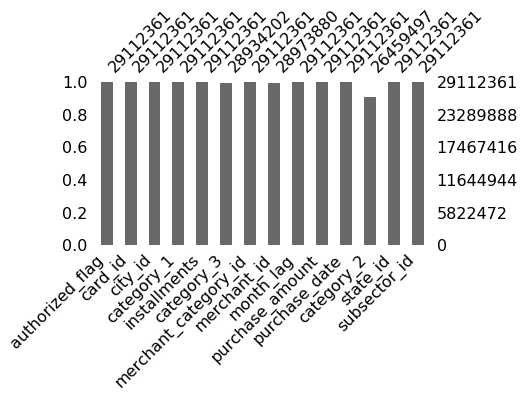

In [5]:
msno.bar(historical_transactions,figsize=(6,3))

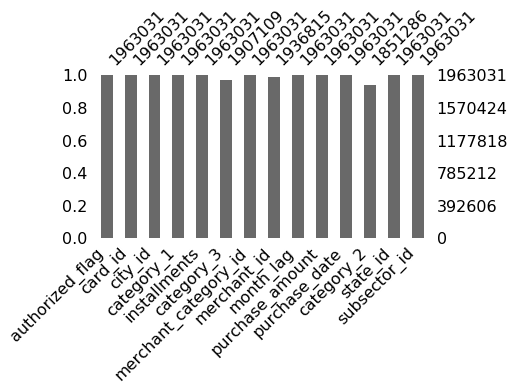

In [6]:
msno.bar(new_transactions,figsize=(6,3))

# FILLING NANS

In [7]:
historical_transactions['category_2'].value_counts()

1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64

In [8]:
new_transactions['category_2'].value_counts()

1.0    1058242
3.0     289525
5.0     259266
4.0     178590
2.0      65663
Name: category_2, dtype: int64

In [9]:
historical_transactions['category_3'].value_counts(dropna=False)

A      15411747
B      11677522
C       1844933
NaN      178159
Name: category_3, dtype: int64

In [10]:
new_transactions['category_3'].value_counts(dropna=False)

A      922244
B      836178
C      148687
NaN     55922
Name: category_3, dtype: int64

In [11]:
historical_transactions['category_2'] = historical_transactions['category_2'].fillna(1.0)
new_transactions['category_2'] = new_transactions['category_2'].fillna(1.0)
historical_transactions['category_3'] = historical_transactions['category_3'].fillna('A')
new_transactions['category_3'] = historical_transactions['category_3'].fillna('A')

In [12]:
new_transactions['category_3'].value_counts(dropna=False)

A    1233150
B     613210
C     116671
Name: category_3, dtype: int64

In [13]:
historical_transactions['merchant_id'].value_counts().head()

M_ID_00a6ca8a8a    1115097
M_ID_e5374dabc0     428619
M_ID_9139332ccc     361385
M_ID_50f575c681     183894
M_ID_fc7d7969c3     177040
Name: merchant_id, dtype: int64

In [14]:
new_transactions['merchant_id'].value_counts().head()

M_ID_00a6ca8a8a    23018
M_ID_cd2c0b07e9    19118
M_ID_9139332ccc    14220
M_ID_50f575c681    13778
M_ID_725a60d404     7029
Name: merchant_id, dtype: int64

In [15]:
historical_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [16]:
test['first_active_month'].fillna('2017-09',inplace=True)# only one row is empty

# DATE

In [17]:
test['first_active_month'].value_counts().head()

2017-09    8806
2017-10    8451
2017-08    8299
2017-11    7807
2017-07    7344
Name: first_active_month, dtype: int64

In [18]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [19]:
train['active_year'] = train['first_active_month'].progress_apply(lambda x: int(str(x)[:4]) )
train['active_month'] = train['first_active_month'].progress_apply(lambda x: int(str(x)[5:]) )
test['active_year'] = test['first_active_month'].progress_apply(lambda x: int(str(x)[:4]) )
test['active_month'] = test['first_active_month'].progress_apply(lambda x: int(str(x)[5:]) )

100%|██████████| 123623/123623 [00:00<00:00, 743056.77it/s]


In [20]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_da2090f28e,69,N,0,A,623,M_ID_f001319a61,-11,-0.686802,2017-01-01 00:00:08,1.0,9,4
1,Y,C_ID_efced389a0,76,N,1,B,842,M_ID_18038b5ae7,-12,-0.566590,2017-01-01 00:00:59,3.0,2,37
2,Y,C_ID_83561fe74a,233,N,1,B,661,M_ID_52d3026407,-13,-0.559227,2017-01-01 00:01:41,1.0,9,8
3,Y,C_ID_479fd6392a,-1,Y,1,B,839,M_ID_e5374dabc0,-1,-0.737892,2017-01-01 00:02:03,1.0,-1,29
4,Y,C_ID_1cf6056088,69,N,0,A,278,M_ID_2cf6dc1f6f,-4,0.004418,2017-01-01 00:02:12,1.0,9,37


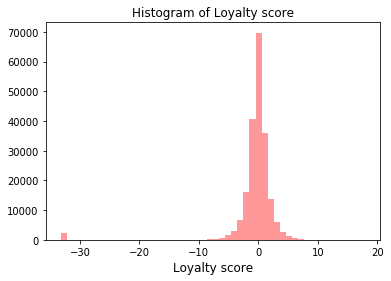

In [21]:
plt.figure(figsize=(6,4))
sns.distplot(train['target'].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [22]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,active_year,active_month
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,2017,6
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,2016,8
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,2017,9
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11


In [23]:
%%time
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])

CPU times: user 10.4 s, sys: 524 ms, total: 11 s
Wall time: 10.8 s


In [24]:
historical_transactions['date'] = historical_transactions['purchase_date'].dt.date
new_transactions['date'] = new_transactions['purchase_date'].dt.date

In [25]:
historical_transactions['date'].nunique(), historical_transactions['date'].min(),historical_transactions['date'].max()

(424, datetime.date(2017, 1, 1), datetime.date(2018, 2, 28))

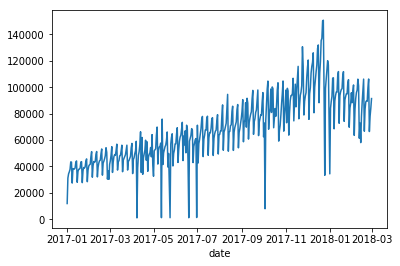

In [26]:
historical_transactions.groupby(['date'])['card_id'].count().plot(kind = 'line')

In [27]:
new_transactions['date'].nunique(), new_transactions['date'].min(),new_transactions['date'].max()

(426, datetime.date(2017, 3, 1), datetime.date(2018, 4, 30))

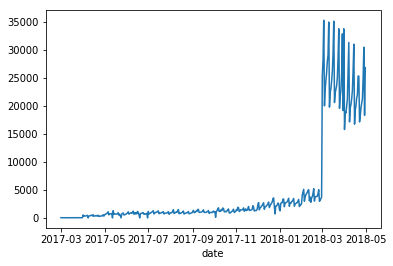

In [28]:
new_transactions.groupby(['date'])['card_id'].count().plot(kind = 'line')

# historical_transactions

In [32]:
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].apply(lambda x: 1 if x =='Y' else 0)
temp = historical_transactions.groupby('card_id')['authorized_flag'].agg(['sum','count','min','max','std','mean','median'])
temp = temp.reset_index(drop=False)
temp.columns = ['card_id'] + ['af_' + str(x) for x in temp.columns if x != 'card_id' ]
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

# city_id

In [34]:
def return_second(x):
    try:
        return Counter(x).most_common()[1][0]
    except:
        return np.nan

def return_second_num(x):
    try:
        return Counter(x).most_common()[1][1]
    except:
        return np.nan
def return_third(x):
    try:
        return Counter(x).most_common()[2][0]
    except:
        return np.nan
def return_third_num(x):
    try:
        return Counter(x).most_common()[2][1]
    except:
        return np.nan

In [35]:
#How many unique city visited
temp = historical_transactions.groupby('card_id')['city_id'].progress_apply(set).apply(len)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','how_many_city_visited']
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:30<00:00, 10772.95it/s]


In [36]:
#Most visited cities
temp = historical_transactions.groupby('card_id')['city_id'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','most_visited_cities']
temp['most_visited_city'] = temp['most_visited_cities'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_visited_city'] = temp['most_visited_cities'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_visited_city'] = temp['most_visited_cities'].progress_apply(lambda x:return_second(x))
temp['num_second_most_visited_city'] = temp['most_visited_cities'].progress_apply(lambda x:return_second_num(x))
temp['third_most_visited_city'] = temp['most_visited_cities'].progress_apply(lambda x: return_third(x))
temp['num_third_most_visited_city'] = temp['most_visited_cities'].progress_apply(lambda x: return_third_num(x))
used_list = [x for x in list(temp.columns) if x != 'most_visited_cities']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:03<00:00, 83189.40it/s]


# category_1

In [37]:
temp = historical_transactions.groupby('card_id')['category_1'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','category_1_numbers']
temp['most_common_category_1'] = temp['category_1_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_common_category_1'] = temp['category_1_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_common_category_1'] = temp['category_1_numbers'].progress_apply(lambda x: return_second(x))
temp['num_second_most_common_category_1'] = temp['category_1_numbers'].progress_apply(lambda x: return_second_num(x))
used_list = [x for x in list(temp.columns) if x != 'category_1_numbers']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:02<00:00, 113093.82it/s]


# installments

In [38]:
%%time
temp = historical_transactions.groupby('card_id')['installments'].agg(['sum','count','min','max','std','mean','median'])
temp = temp.reset_index(drop=False)
temp.columns = ['card_id'] + ['ins_' + str(x) for x in temp.columns if x != 'card_id' ]
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

CPU times: user 13 s, sys: 408 ms, total: 13.4 s
Wall time: 13.4 s


# category_3

In [39]:
temp = historical_transactions.groupby('card_id')['category_3'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','category_3_numbers']
temp['most_common_category_3'] = temp['category_3_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_common_category_3'] = temp['category_3_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_common_category_3'] = temp['category_3_numbers'].progress_apply(lambda x: return_second(x))
temp['num_second_most_common_category_3'] = temp['category_3_numbers'].progress_apply(lambda x: return_second_num(x))
temp['third_most_common_category_3'] = temp['category_3_numbers'].progress_apply(lambda x: return_third(x))
temp['num_third_most_common_category_3'] = temp['category_3_numbers'].progress_apply(lambda x: return_third_num(x))
used_list = [x for x in list(temp.columns) if x != 'category_3_numbers']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:03<00:00, 88522.51it/s]


# merchant_category_id

In [40]:
#How_many_merchant_category_id_visited
temp = historical_transactions.groupby('card_id')['merchant_category_id'].progress_apply(set).apply(len)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','how_many_merchant_category_id_visited']
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:34<00:00, 9510.19it/s] 


In [41]:
temp = historical_transactions.groupby('card_id')['merchant_category_id'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','merchant_category_id_numbers']
temp['most_common_merchant_category_id'] = temp['merchant_category_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_common_merchant_category_id'] = temp['merchant_category_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_common_merchant_category_id'] = temp['merchant_category_id_numbers'].progress_apply(lambda x: return_second(x))
temp['num_second_most_common_merchant_category_id'] = temp['merchant_category_id_numbers'].progress_apply(lambda x: return_second_num(x))
temp['third_most_common_merchant_category_id'] = temp['merchant_category_id_numbers'].progress_apply(lambda x: return_third(x))
temp['num_third_most_common_merchant_category_id'] = temp['merchant_category_id_numbers'].progress_apply(lambda x: return_third_num(x))
used_list = [x for x in list(temp.columns) if x != 'merchant_category_id_numbers']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:06<00:00, 53065.50it/s]


# merchant_id

In [42]:
#How many unique merchant visited
temp = historical_transactions.groupby('card_id')['merchant_id'].progress_apply(set).apply(len)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','how_many_merchant_id_visited']
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:42<00:00, 7645.15it/s]


In [43]:
temp = historical_transactions.groupby('card_id')['merchant_id'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','merchant_id_numbers']
temp['most_common_merchant_id'] = temp['merchant_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_common_merchant_id'] = temp['merchant_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_common_merchant_id'] = temp['merchant_id_numbers'].progress_apply(lambda x: return_second(x))
temp['num_second_most_common_merchant_id'] = temp['merchant_id_numbers'].progress_apply(lambda x: return_second_num(x))
temp['third_most_common_merchant_id'] = temp['merchant_id_numbers'].progress_apply(lambda x: return_third(x))
temp['num_third_most_common_merchant_id'] = temp['merchant_id_numbers'].progress_apply(lambda x: return_third_num(x))
used_list = [x for x in list(temp.columns) if x != 'merchant_id_numbers']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:06<00:00, 51611.20it/s]


# binned_purchase_amount

In [44]:
bins = np.percentile(historical_transactions['purchase_amount'],q=[0,1,5,10,25,50,75,90,95,99,100])
historical_transactions['binned_purchase_amount'] = pd.cut(historical_transactions['purchase_amount'],bins,labels=[1,2,3,4,5,6,7,8,9,10],include_lowest=True)
historical_transactions['binned_purchase_amount'] = historical_transactions['binned_purchase_amount'].astype(int)

In [45]:
temp = historical_transactions.groupby('card_id')['binned_purchase_amount'].agg(['sum','min','max','std','mean','median'])
temp = temp.reset_index(drop=False)
temp.columns = ['card_id'] + ['binned_purchase_amount_' + str(x) for x in temp.columns if x != 'card_id' ]
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

# month_lag

In [46]:
temp = historical_transactions.groupby('card_id')['month_lag'].agg(['sum','min','max','std','mean','median'])
temp = temp.reset_index(drop=False)
temp.columns = ['card_id'] + ['month_lag_' + str(x) for x in temp.columns if x != 'card_id' ]
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

# purchase_amount

In [47]:
temp = historical_transactions.groupby('card_id')['purchase_amount'].agg(['sum','min','max','std','mean','median'])
temp = temp.reset_index(drop=False)
temp.columns = ['card_id'] + ['purchase_amount_' + str(x) for x in temp.columns if x != 'card_id' ]
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

# purchase_date

In [48]:
temp = historical_transactions.groupby('card_id')['purchase_date'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','purchase_date_numbers']

100%|██████████| 325540/325540 [02:27<00:00, 2213.35it/s]


In [49]:
temp['size_of_purchase_date'] = temp['purchase_date_numbers'].progress_apply(len)

100%|██████████| 325540/325540 [00:00<00:00, 856318.61it/s] 


In [50]:
temp['min_purchase_date'] = temp['purchase_date_numbers'].progress_apply(lambda x: x[0])
temp['max_purchase_date'] = temp['purchase_date_numbers'].progress_apply(lambda x: x[-1])

100%|██████████| 325540/325540 [00:00<00:00, 504730.73it/s]


In [51]:
temp['size_of_purchase_date'].head().apply(lambda x: int(x/2))

0     74
1     61
2     33
3    108
4     72
Name: size_of_purchase_date, dtype: int64

In [52]:
temp['25_percentile_purchase_date'] = temp['size_of_purchase_date'].progress_apply(lambda x: int(x/4))
temp['50_percentile_purchase_date'] = temp['size_of_purchase_date'].progress_apply(lambda x: int(x/2))
temp['75_percentile_purchase_date'] = temp['size_of_purchase_date'].progress_apply(lambda x: int(3*x/4))

100%|██████████| 325540/325540 [00:00<00:00, 770912.77it/s]


In [53]:
def get_25_percent(x):
    a = x['size_of_purchase_date']
    if a >=4:
        c = x['purchase_date_numbers']
        d = x['25_percentile_purchase_date']
        return c[d]
    else:
        b = x['min_purchase_date']
        return b

In [54]:
def get_50_percent(x):
    a = x['size_of_purchase_date']
    if a >=4:
        c = x['purchase_date_numbers']
        d = x['50_percentile_purchase_date']
        return c[d]
    else:
        b = x['min_purchase_date']
        return b

In [55]:
def get_75_percent(x):
    a = x['size_of_purchase_date']
    if a >=4:
        c = x['purchase_date_numbers']
        d = x['75_percentile_purchase_date']
        return c[d]
    else:
        b = x['min_purchase_date']
        return b

In [56]:
temp['25_percentile_purchase_date'] = temp.progress_apply(get_25_percent,axis=1)
temp['50_percentile_purchase_date'] = temp.progress_apply(get_50_percent,axis=1)
temp['75_percentile_purchase_date'] = temp.progress_apply(get_75_percent,axis=1)

100%|██████████| 325540/325540 [00:17<00:00, 18630.62it/s]


In [57]:
temp['max_75_percentile_diff'] = temp['max_purchase_date'] - temp['75_percentile_purchase_date']
temp['max_75_percentile_diff'] = temp['max_75_percentile_diff'].progress_apply(lambda x: x.days)
temp['max_50_percentile_diff'] = temp['max_purchase_date'] - temp['50_percentile_purchase_date']
temp['max_50_percentile_diff'] = temp['max_50_percentile_diff'].progress_apply(lambda x: x.days)
temp['max_25_percentile_diff'] = temp['max_purchase_date'] - temp['25_percentile_purchase_date']
temp['max_25_percentile_diff'] = temp['max_25_percentile_diff'].progress_apply(lambda x: x.days)
temp['max_min_diff'] = temp['max_purchase_date'] - temp['min_purchase_date']
temp['max_min_diff'] = temp['max_min_diff'].progress_apply(lambda x: x.days)

temp['75_percentile_50_percentile_diff'] = temp['75_percentile_purchase_date'] - temp['50_percentile_purchase_date']
temp['75_percentile_50_percentile_diff'] = temp['75_percentile_50_percentile_diff'].progress_apply(lambda x: x.days)
temp['75_percentile_25_percentile_diff'] = temp['75_percentile_purchase_date'] - temp['25_percentile_purchase_date']
temp['75_percentile_25_percentile_diff'] = temp['75_percentile_25_percentile_diff'].progress_apply(lambda x: x.days)
temp['75_percentile_min_diff'] = temp['75_percentile_purchase_date'] - temp['min_purchase_date']
temp['75_percentile_min_diff'] = temp['75_percentile_min_diff'].progress_apply(lambda x: x.days)

temp['50_percentile_25_percentile_diff'] = temp['50_percentile_purchase_date'] - temp['25_percentile_purchase_date']
temp['50_percentile_25_percentile_diff'] = temp['50_percentile_25_percentile_diff'].progress_apply(lambda x: x.days)
temp['50_percentile_min_diff'] = temp['50_percentile_purchase_date'] - temp['min_purchase_date']
temp['50_percentile_min_diff'] = temp['50_percentile_min_diff'].progress_apply(lambda x: x.days)

temp['25_percentile_min_diff'] = temp['25_percentile_purchase_date'] - temp['min_purchase_date']
temp['25_percentile_min_diff'] = temp['25_percentile_min_diff'].progress_apply(lambda x: x.days)


100%|██████████| 325540/325540 [00:02<00:00, 148527.42it/s]


In [58]:
used_columns = ['card_id'] + list(temp.columns[-10:])

In [59]:
train = train.merge(temp[used_columns],how = 'left',on = 'card_id')
test = test.merge(temp[used_columns],how = 'left',on = 'card_id')

# category_2

In [60]:
#how_many_unique_category_2
temp = historical_transactions.groupby('card_id')['category_2'].progress_apply(set).apply(len)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','how_many_unique_category_2']
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:27<00:00, 11855.30it/s]


In [61]:
temp = historical_transactions.groupby('card_id')['category_2'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','category_2_numbers']
temp['most_common_category_2'] = temp['category_2_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_common_category_2'] = temp['category_2_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_common_category_2'] = temp['category_2_numbers'].progress_apply(lambda x: return_second(x))
temp['num_second_most_common_category_2'] = temp['category_2_numbers'].progress_apply(lambda x: return_second_num(x))
temp['third_most_common_category_2'] = temp['category_2_numbers'].progress_apply(lambda x: return_third(x))
temp['num_third_most_common_category_2'] = temp['category_2_numbers'].progress_apply(lambda x: return_third_num(x))
used_list = [x for x in list(temp.columns) if x != 'category_2_numbers']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:05<00:00, 59357.05it/s]


# state_id

In [62]:
#how_many_unique_state_id
temp = historical_transactions.groupby('card_id')['state_id'].progress_apply(set).apply(len)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','how_many_unique_state_id']
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:29<00:00, 11045.59it/s]


In [63]:
temp = historical_transactions.groupby('card_id')['state_id'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','state_id_numbers']
temp['most_common_state_id'] = temp['state_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_common_state_id'] = temp['state_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_common_state_id'] = temp['state_id_numbers'].progress_apply(lambda x: return_second(x))
temp['num_second_most_common_state_id'] = temp['state_id_numbers'].progress_apply(lambda x: return_second_num(x))
temp['third_most_common_state_id'] = temp['state_id_numbers'].progress_apply(lambda x: return_third(x))
temp['num_third_most_common_state_id'] = temp['state_id_numbers'].progress_apply(lambda x: return_third_num(x))
used_list = [x for x in list(temp.columns) if x != 'state_id_numbers']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:03<00:00, 91960.32it/s]


# subsector_id

In [64]:
#how_many_unique_subsector_id
temp = historical_transactions.groupby('card_id')['subsector_id'].progress_apply(set).apply(len)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','how_many_unique_subsector_id']
train = train.merge(temp,how = 'left',on = 'card_id')
test = test.merge(temp,how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:30<00:00, 10741.56it/s]


In [65]:
temp = historical_transactions.groupby('card_id')['subsector_id'].progress_apply(list)
temp = temp.reset_index(drop=False)
temp.columns = ['card_id','subsector_id_numbers']
temp['most_common_subsector_id'] = temp['subsector_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][0])
temp['num_most_common_subsector_id'] = temp['subsector_id_numbers'].progress_apply(lambda x: Counter(x).most_common()[0][1])
temp['second_most_common_subsector_id'] = temp['subsector_id_numbers'].progress_apply(lambda x: return_second(x))
temp['num_second_most_common_subsector_id'] = temp['subsector_id_numbers'].progress_apply(lambda x: return_second_num(x))
temp['third_most_common_subsector_id'] = temp['subsector_id_numbers'].progress_apply(lambda x: return_third(x))
temp['num_third_most_common_subsector_id'] = temp['subsector_id_numbers'].progress_apply(lambda x: return_third_num(x))
used_list = [x for x in list(temp.columns) if x != 'subsector_id_numbers']
train = train.merge(temp[used_list],how = 'left',on = 'card_id')
test = test.merge(temp[used_list],how = 'left',on = 'card_id')

100%|██████████| 325540/325540 [00:03<00:00, 81626.02it/s]


In [66]:
print(train.shape,test.shape)

(201917, 102) (123623, 101)


In [67]:
train.columns = list(train.columns[:8]) + ['h_'+ str(x) for x in list(train.columns[8:])]

In [68]:
test.columns = list(test.columns[:7]) + ['h_'+ str(x) for x in list(test.columns[7:])]

In [69]:
train.to_csv('train_processed.csv',index=False)
test.to_csv('test_processed.csv',index=False)